In [2]:
import sys
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler,StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import importlib
from sklearn.decomposition import PCA

path_src = os.path.abspath('../../../src')

# Agregar esa ruta al sys.path si no está ya
if path_src not in sys.path:
    sys.path.append(path_src)

# Importar utils normalmente
import utils
importlib.reload(utils)

# Importar funciones específicas
from utils import (
    kmeans_clustering_mlflow,
    transform_pca,
    silhouette_analysis,
    elbow_method,
    plot_davies_bouldin_scores,
    evaluar_calinski_harabasz
)


In [3]:
rfm_clientes_locales = pd.read_csv('../../../dataset/rfm_clientes_locales.csv')



print(rfm_clientes_locales.columns)

print("cantidad de columnas: ", len(rfm_clientes_locales.columns))

print("cantidad de filas: ", len(rfm_clientes_locales))

Index(['id_cliente', 'Recency', 'Frequency', 'Monetary', 'horario_promedio',
       '2010-12', '2011-01', '2011-02', '2011-03', '2011-04', '2011-05',
       '2011-06', '2011-07', '2011-08', '2011-09', '2011-10', '2011-11',
       '2011-12'],
      dtype='object')
cantidad de columnas:  18
cantidad de filas:  3915


In [5]:
rfm_clientes_locales.head()

id_cliente  Recency  Frequency  Monetary  horario_promedio  2010-12  \
0     12747.0        3         11   4196.01                12   706.27   
1     12748.0        1        206  31650.78                14  4142.77   
2     12749.0        4          5   4040.88                12     0.00   
3     12820.0        4          4    942.34                13     0.00   
4     12821.0      215          1     92.72                15     0.00   

   2011-01  2011-02  2011-03  2011-04  2011-05  2011-06  2011-07  2011-08  \
0   303.04     0.00   310.78     0.00   771.31   376.30     0.00   301.70   
1   417.12   351.59  1165.37   665.57  2219.17  1923.62  1081.45   887.67   
2     0.00     0.00     0.00     0.00   859.10     0.00     0.00  1896.13   
3   170.46     0.00     0.00     0.00     0.00     0.00     0.00     0.00   
4     0.00     0.00     0.00     0.00    92.72     0.00     0.00     0.00   

   2011-09  2011-10  2011-11  2011-12  
0     0.00   675.38   312.73   438.50  
1  6047.51  2149.30  9601.49   998.15  
2     0.00     0.00   522.59   763.06  
3   217.77   343.76     0.00   210.35  
4     0.00     0.00     0.00     0.00

In [6]:
# Limpieza de outliers usando el método IQR para Recency, Frequency y Monetary
def remove_outliers_iqr(df, columns):
    """
    Elimina outliers usando el método IQR (Interquartile Range)
    """
    df_clean = df.copy()
    
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Filtramos los outliers
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    
    return df_clean

# Columnas a limpiar
columns_to_clean = ['Recency', 'Frequency', 'Monetary']

# Mostrar estadísticas antes de la limpieza
print("Estadísticas ANTES de la limpieza de outliers:")
print(rfm_clientes_locales[columns_to_clean].describe())
print(f"\nCantidad de registros antes: {len(rfm_clientes_locales)}")

# Aplicar limpieza de outliers
rfm_clientes_locales_clean = remove_outliers_iqr(rfm_clientes_locales, columns_to_clean)




Estadísticas ANTES de la limpieza de outliers:
           Recency    Frequency       Monetary
count  3915.000000  3915.000000    3915.000000
mean     92.879693     4.234227    1787.280235
std      99.666473     7.155978    6834.630348
min       1.000000     1.000000       2.900000
25%      18.000000     1.000000     296.670000
50%      51.000000     2.000000     643.760000
75%     144.000000     5.000000    1563.780000
max     374.000000   206.000000  259657.300000

Cantidad de registros antes: 3915


In [7]:
id_cliente= rfm_clientes_locales_clean['id_cliente'].copy()

id_cliente.head()

3    12820.0
4    12821.0
5    12822.0
6    12823.0
7    12824.0
Name: id_cliente, dtype: float64

In [8]:
rfm_clientes_locales_clean.drop(columns=['id_cliente'], inplace=True)

In [9]:
rfm_clientes_locales_clean

Recency  Frequency  Monetary  horario_promedio  2010-12  2011-01  \
3           4          4    942.34                13      0.0   170.46   
4         215          1     92.72                15      0.0     0.00   
5          71          2    948.88                13      0.0     0.00   
6          75          5   1759.50                12      0.0     0.00   
7          60          1    397.12                12      0.0     0.00   
...       ...        ...       ...               ...      ...      ...   
3909       74          1    173.90                11      0.0     0.00   
3910      278          1    180.60                 9      0.0     0.00   
3911      181          1     80.82                10      0.0     0.00   
3912        8          2    178.05                12      0.0     0.00   
3914       43          3   1837.28                10      0.0     0.00   

      2011-02  2011-03  2011-04  2011-05  2011-06  2011-07  2011-08  2011-09  \
3         0.0      0.0      0.0     0.00     0.00      0.0     0.00   217.77   
4         0.0      0.0      0.0    92.72     0.00      0.0     0.00     0.00   
5         0.0      0.0      0.0     0.00     0.00      0.0     0.00   948.88   
6       535.5    459.0      0.0     0.00     0.00      0.0   229.50   535.50   
7         0.0      0.0      0.0     0.00     0.00      0.0     0.00     0.00   
...       ...      ...      ...      ...      ...      ...      ...      ...   
3909      0.0      0.0      0.0     0.00     0.00      0.0     0.00   173.90   
3910      0.0    180.6      0.0     0.00     0.00      0.0     0.00     0.00   
3911      0.0      0.0      0.0     0.00    80.82      0.0     0.00     0.00   
3912      0.0      0.0      0.0     0.00     0.00      0.0   100.21     0.00   
3914      0.0      0.0      0.0   765.28     0.00      0.0     0.00     0.00   

      2011-10  2011-11  2011-12  
3      343.76      0.0   210.35  
4        0.00      0.0     0.00  
5        0.00      0.0     0.00  
6        0.00      0.0     0.00  
7      397.12      0.0     0.00  
...       ...      ...      ...  
3909     0.00      0.0     0.00  
3910     0.00      0.0     0.00  
3911     0.00      0.0     0.00  
3912     0.00      0.0    77.84  
3914  1072.00      0.0     0.00  

[3284 rows x 17 columns]

### Reduccion de dimensionalidad

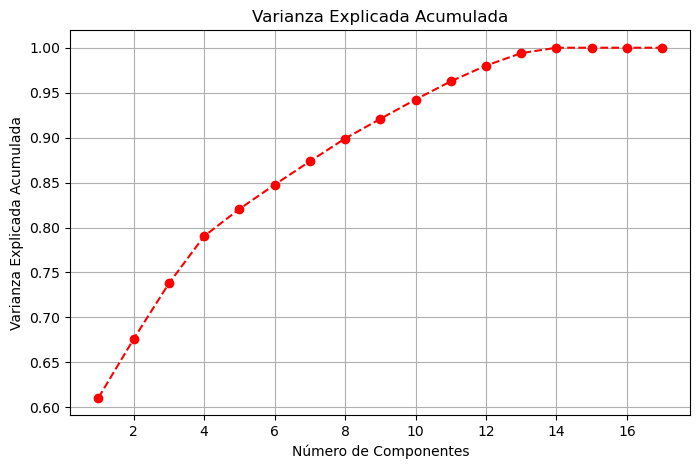

In [10]:
pca=PCA()

pca.fit(rfm_clientes_locales_clean)

var_exp=pca.explained_variance_ratio_

# Graficar varianza acumulada
plt.figure(figsize=(8,5))
plt.plot(range(1, len(var_exp)+1), var_exp.cumsum(), marker='o', linestyle='--', color='red')
plt.ylabel('Varianza Explicada Acumulada')
plt.xlabel('Número de Componentes')
plt.title('Varianza Explicada Acumulada')
plt.grid()
plt.show()

In [ ]:
componentes = transform_pca(rfm_clientes_locales_clean, 5)

# dichas compoenentes la transformamos en un dataframe de pandas , con los mismos indices que el dataframe original , para hacer un analisis psoteriormente de los grupos que forma k-means
dataframe_pca = pd.DataFrame(componentes, columns=['PC1', 'PC2','PC3','PC4','PC5'],index=rfm_clientes_locales_clean.index)

dataframe_pca.head()

PC1       PC2       PC3       PC4       PC5
3 -0.269982 -0.142595  0.017760  0.028126  0.061311
4  0.467073  0.084575  0.190151  0.003781  0.016909
5 -0.064354 -0.051997  0.000188 -0.292406  0.316180
6 -0.374178  0.265024 -0.053286 -0.122208  0.157205
7  0.113712 -0.214248 -0.068477 -0.032582 -0.064566

### k-means

#### Seleccion de cluster con analisis de silueta para k-means

Para n_clusters = 2, el silhouette promedio es: 0.3333
Para n_clusters = 3, el silhouette promedio es: 0.3736
Para n_clusters = 4, el silhouette promedio es: 0.2999
Para n_clusters = 5, el silhouette promedio es: 0.2580
Para n_clusters = 6, el silhouette promedio es: 0.2663
Para n_clusters = 7, el silhouette promedio es: 0.2328
Para n_clusters = 8, el silhouette promedio es: 0.2347
Para n_clusters = 9, el silhouette promedio es: 0.2378
Para n_clusters = 10, el silhouette promedio es: 0.2261
Para n_clusters = 11, el silhouette promedio es: 0.2299
Para n_clusters = 12, el silhouette promedio es: 0.2386
Para n_clusters = 13, el silhouette promedio es: 0.2208
Para n_clusters = 14, el silhouette promedio es: 0.2078


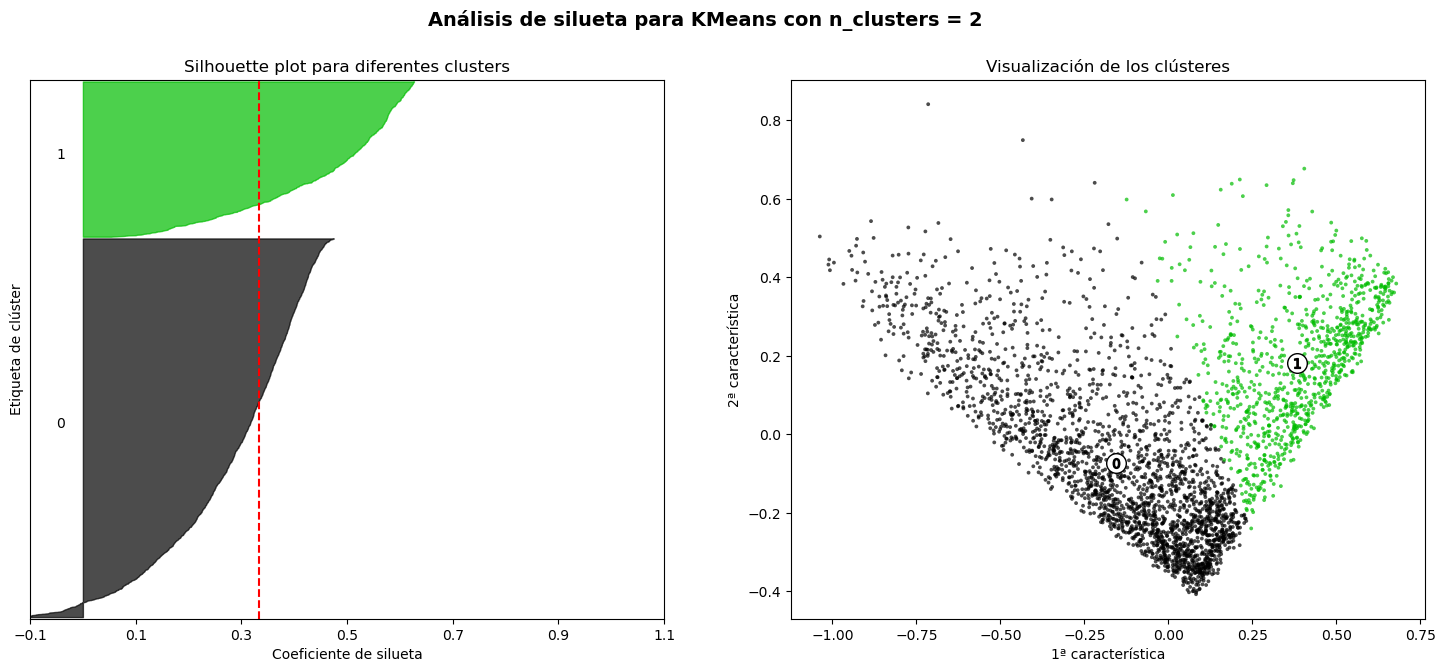

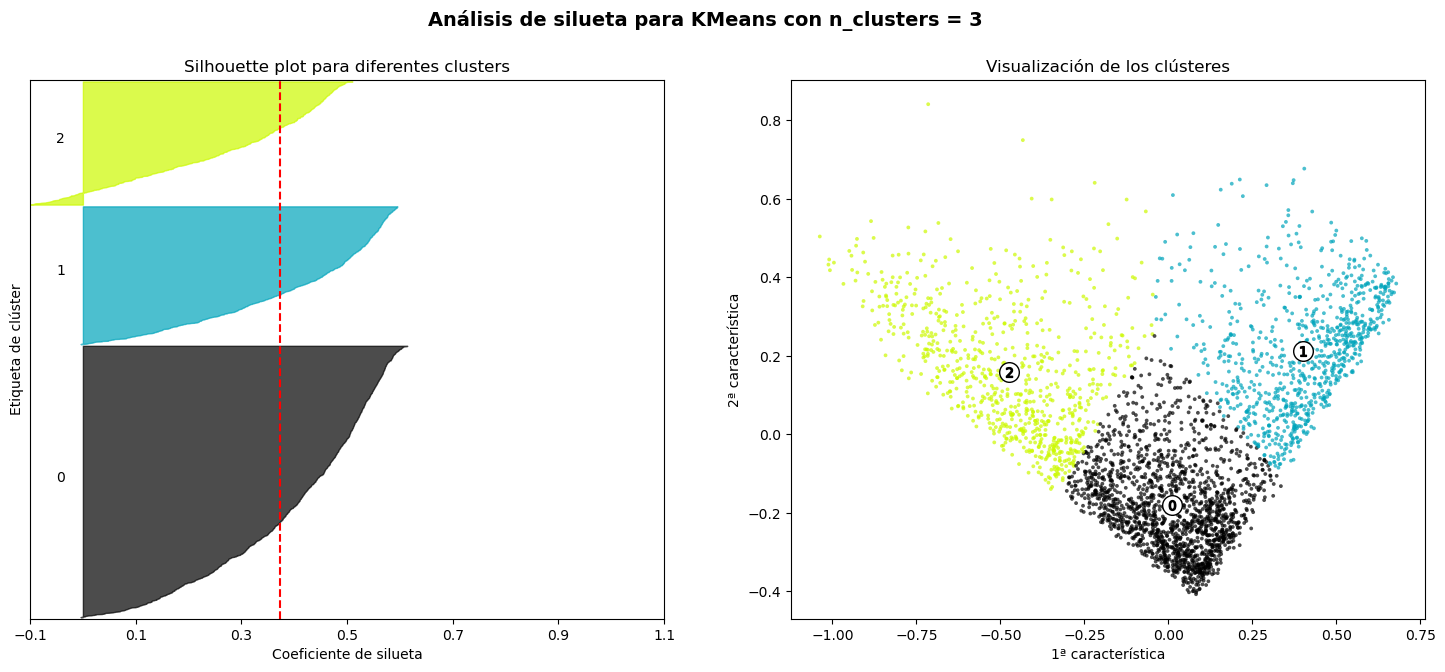

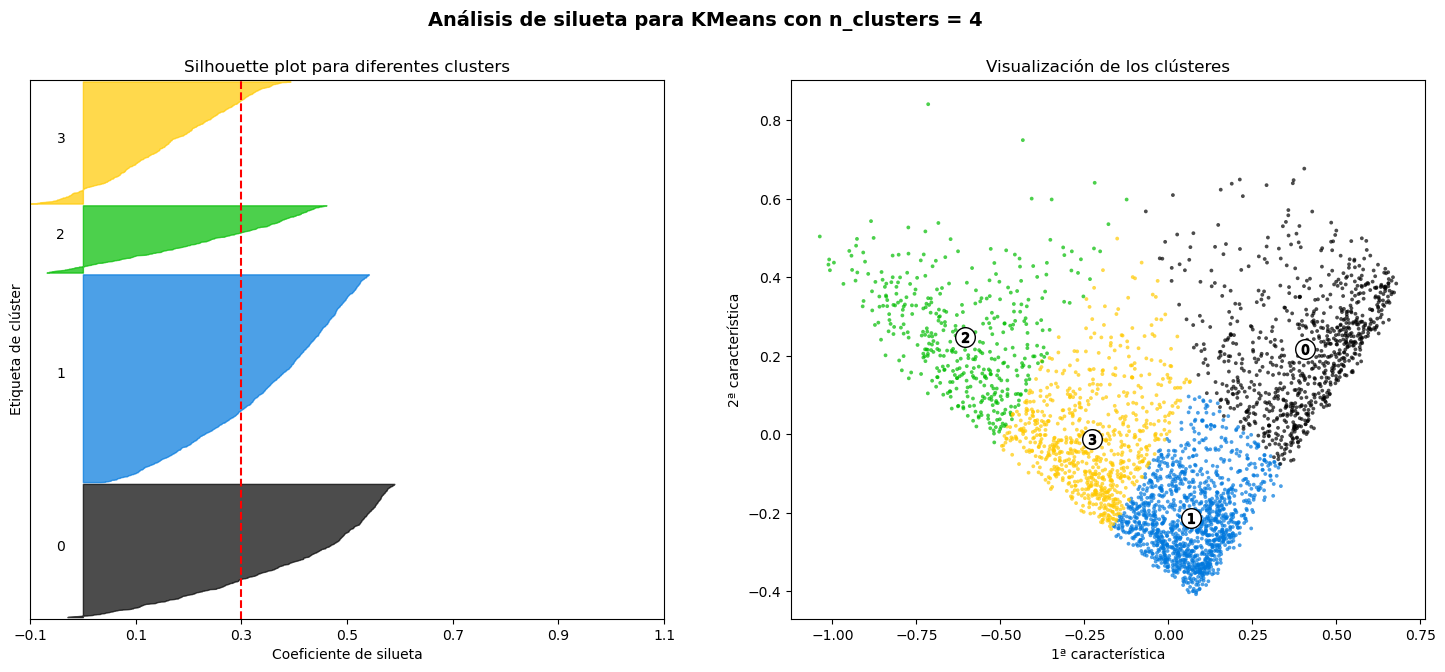

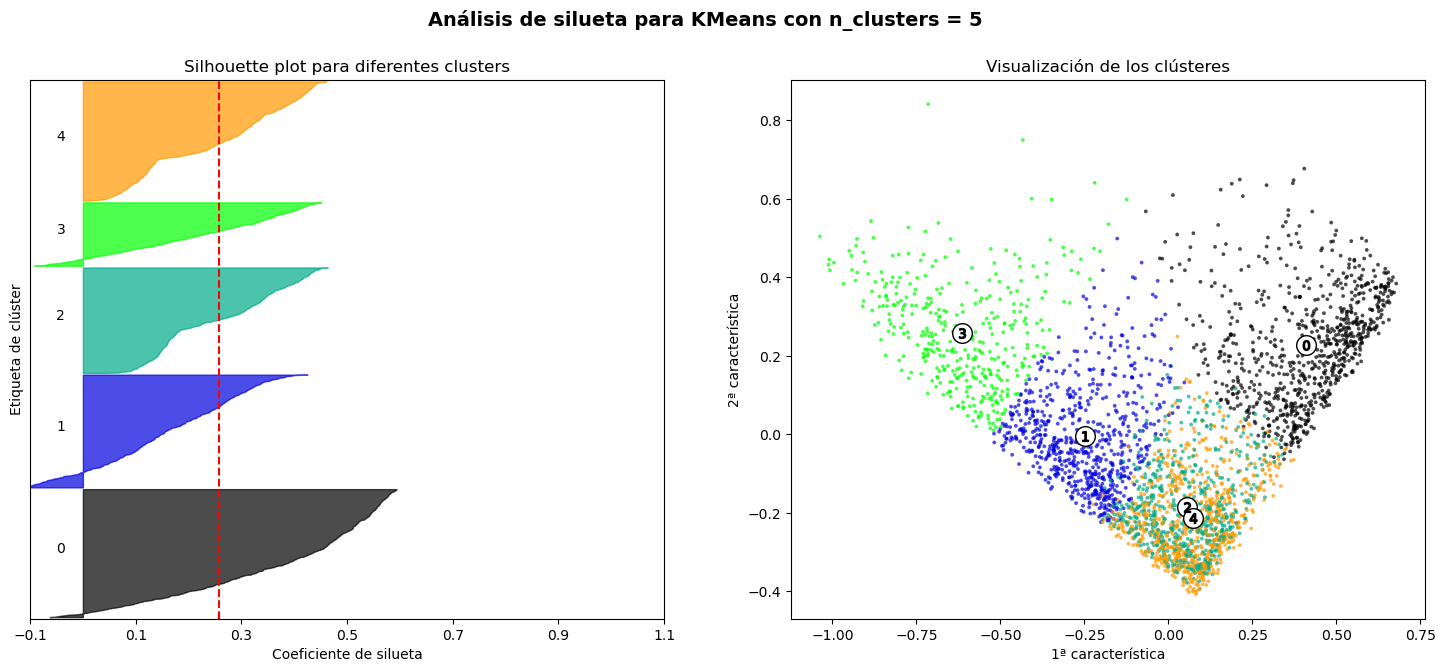

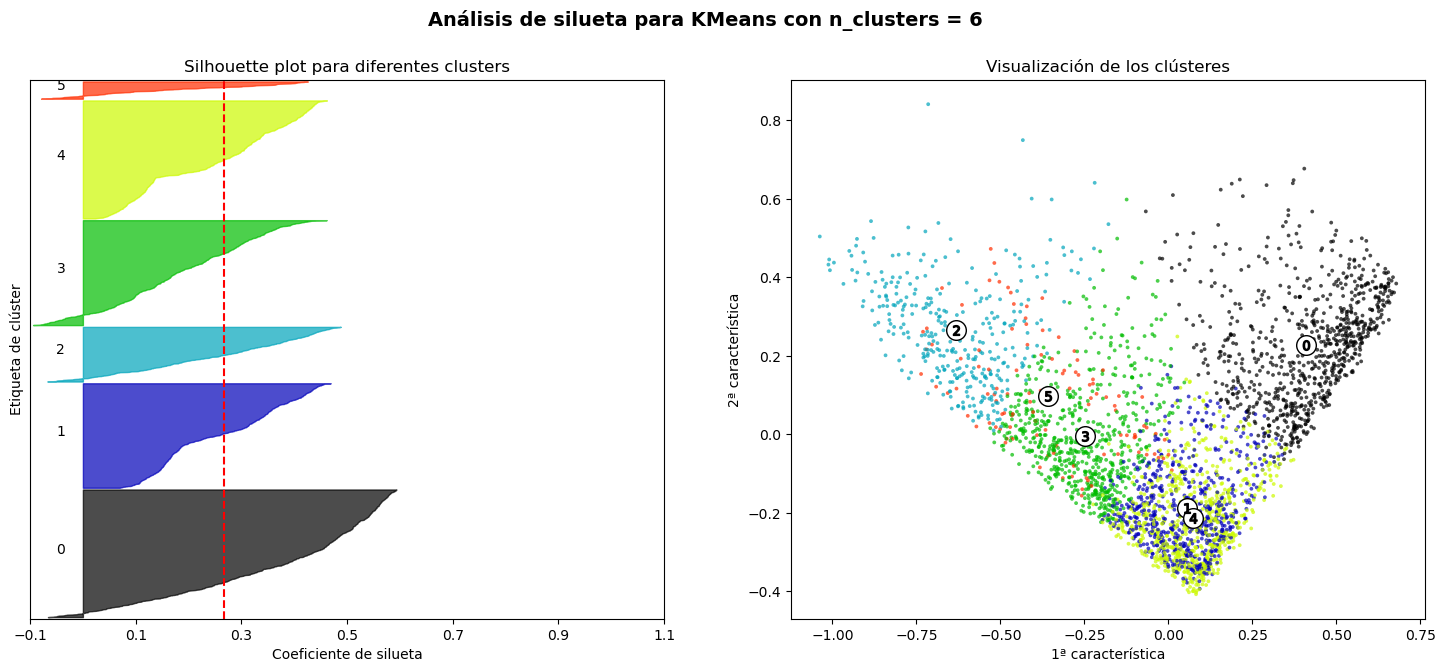

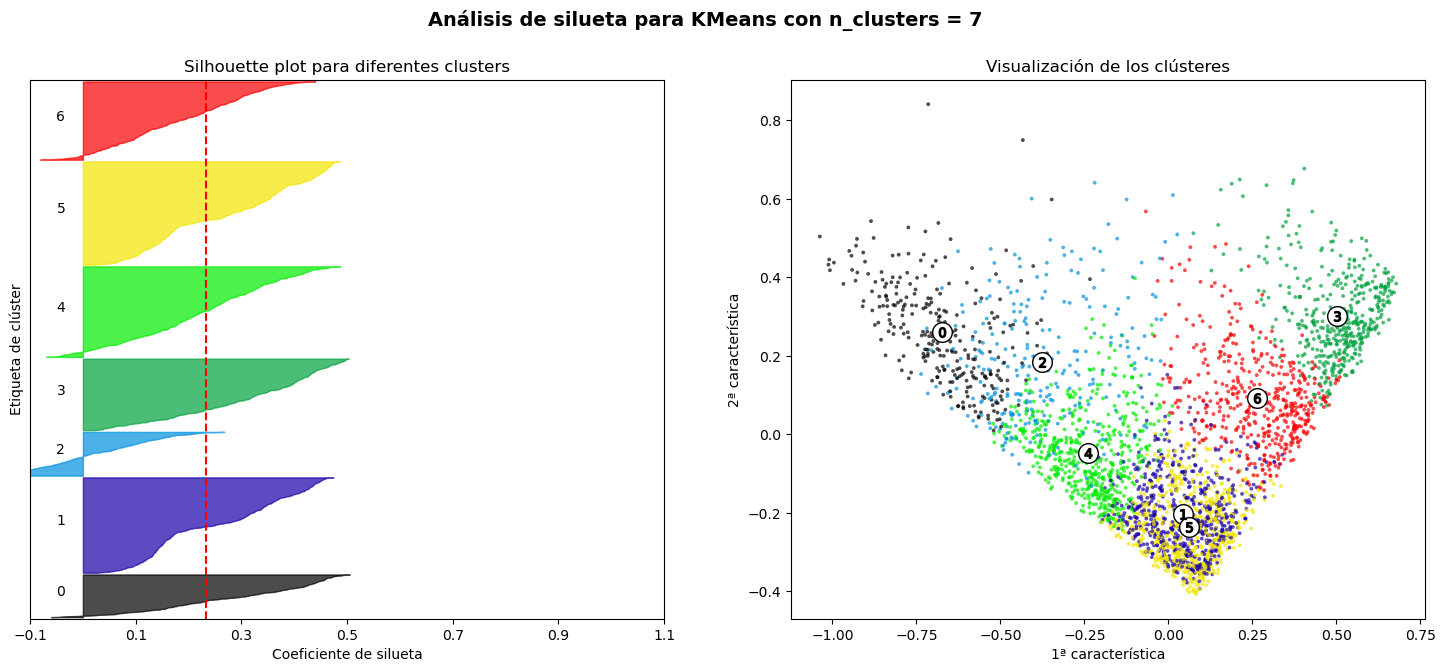

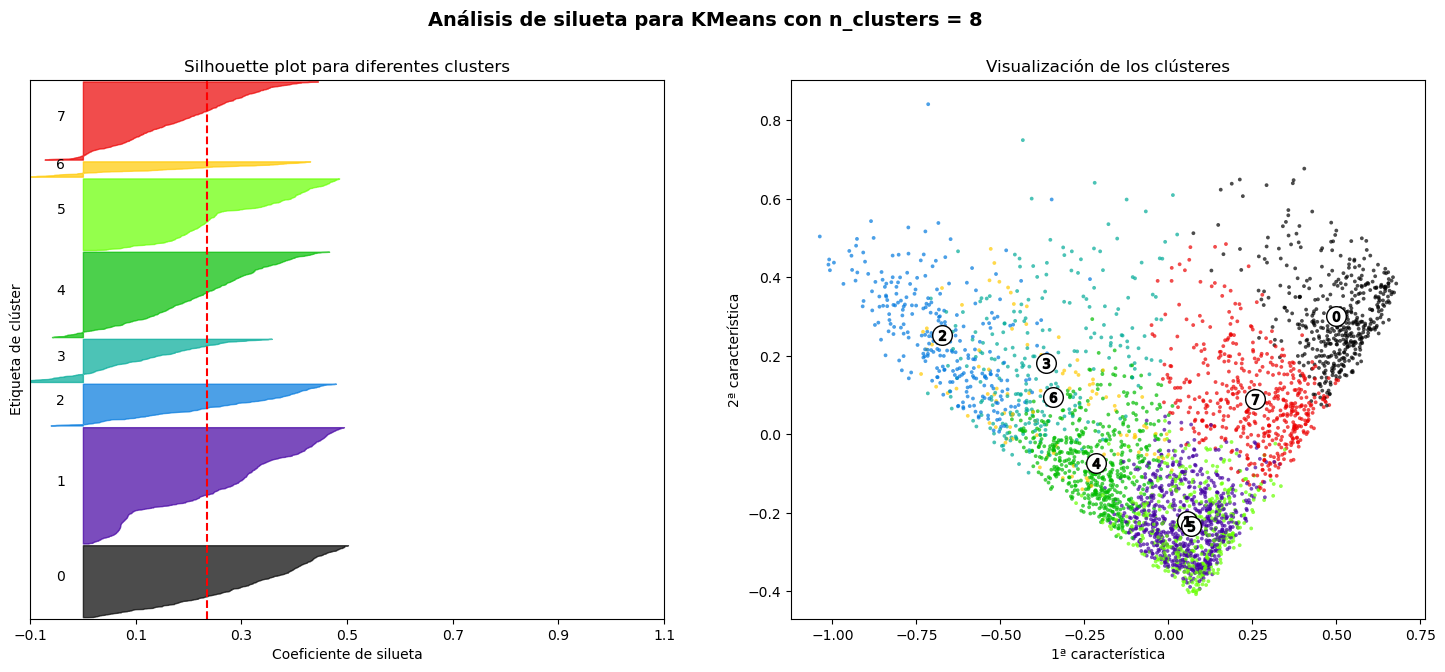

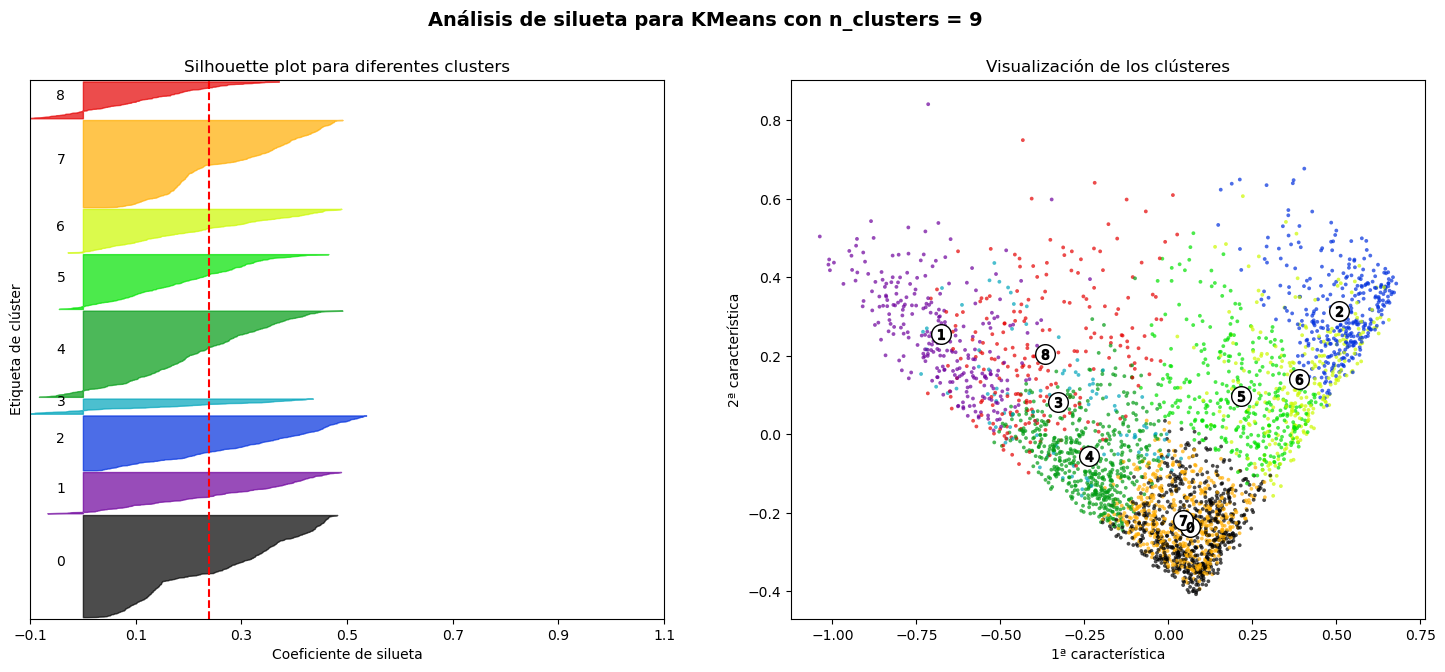

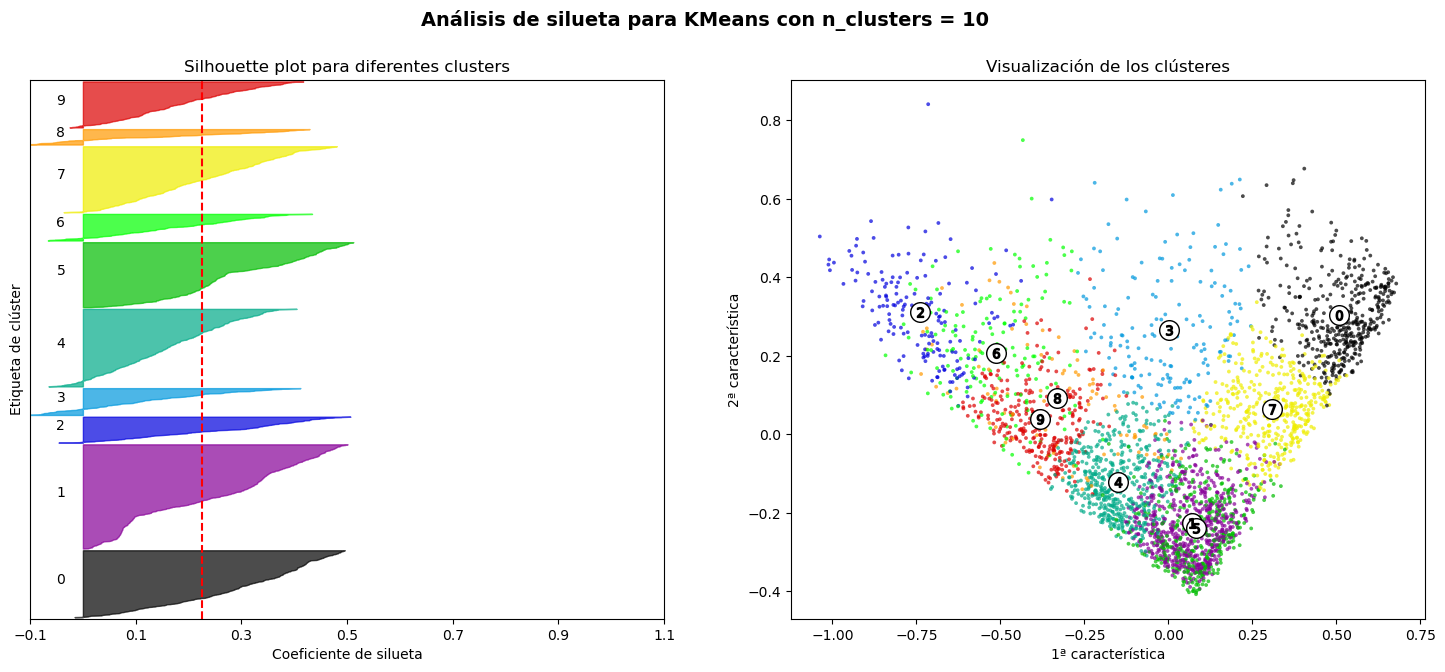

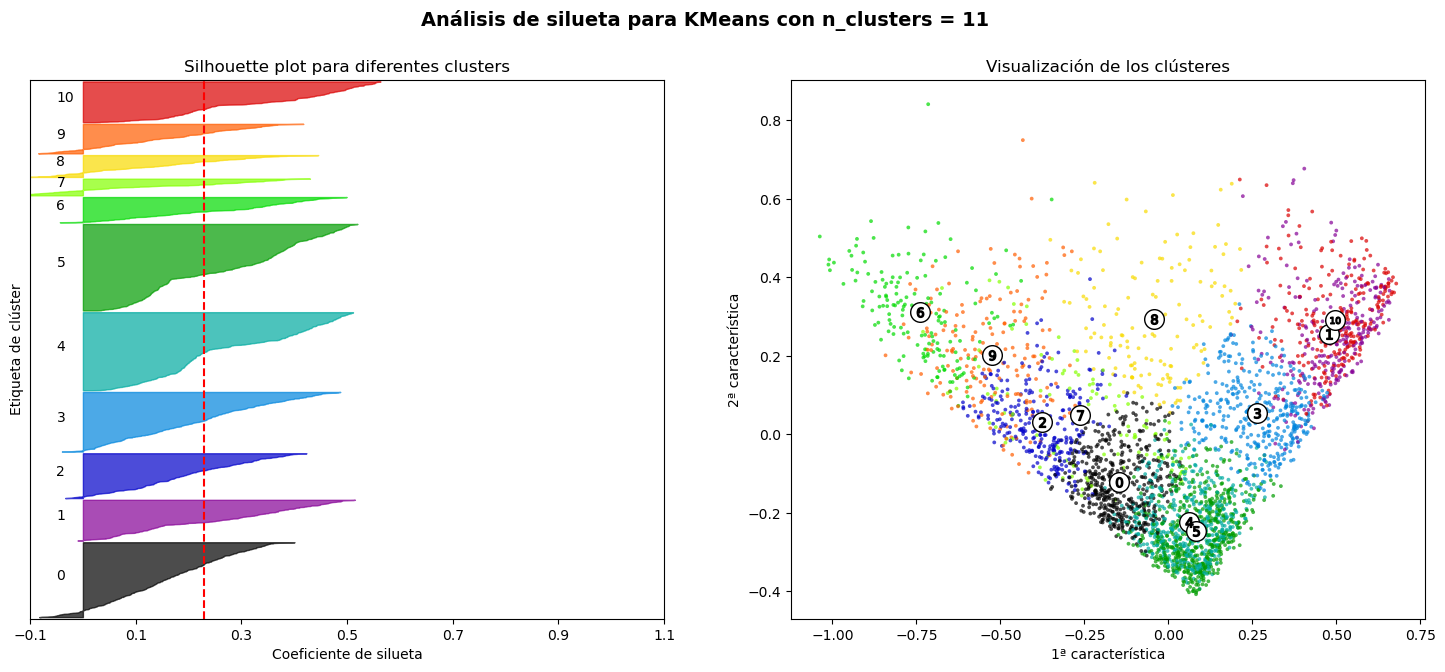

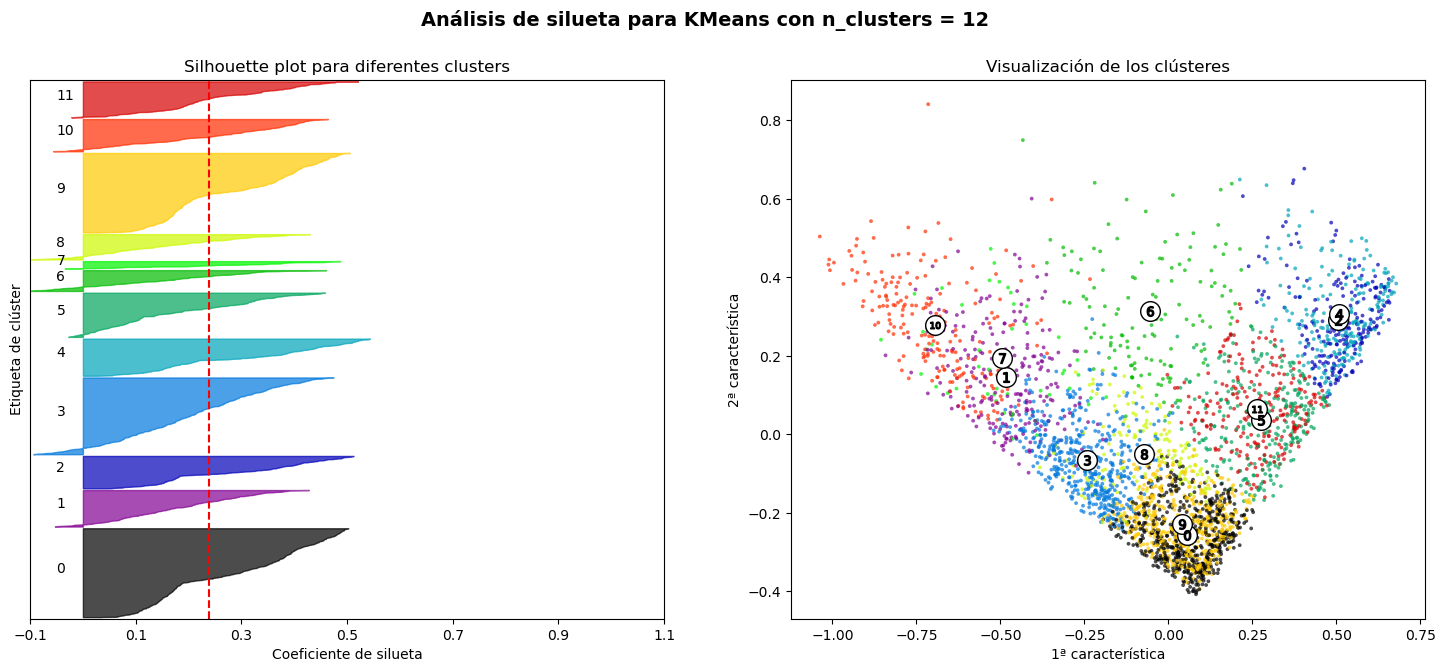

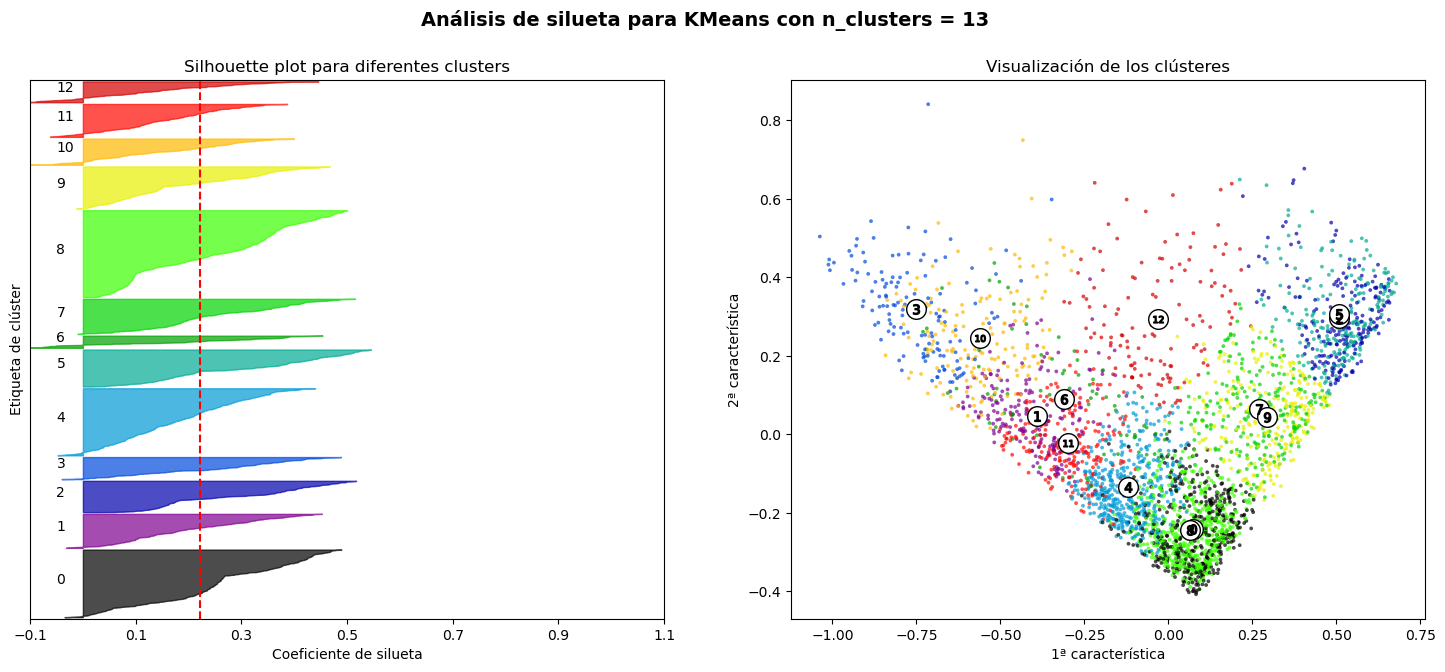

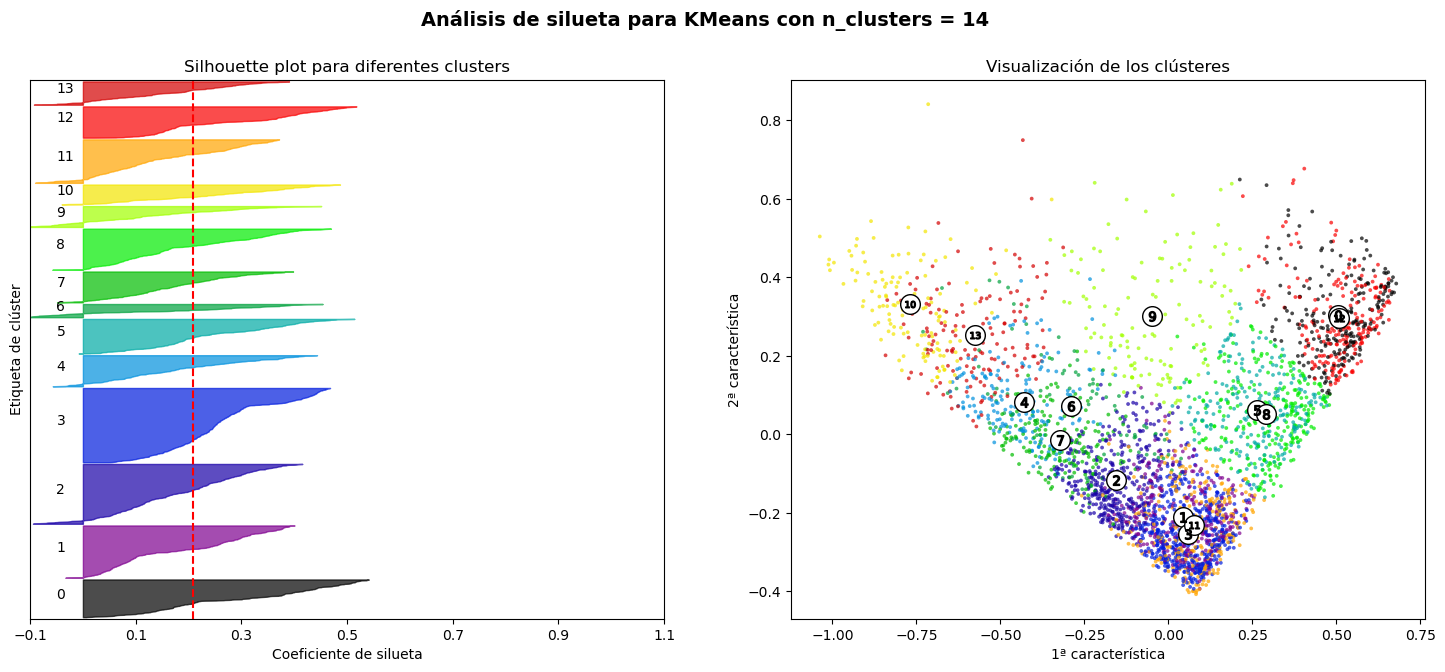

In [12]:
average_silhouette=silhouette_analysis(dataframe_pca.values, range(2, 15))

average_cluster=pd.DataFrame({'n_clusters':range(2,15),'average_silhouette':average_silhouette})


#### metodo del codo

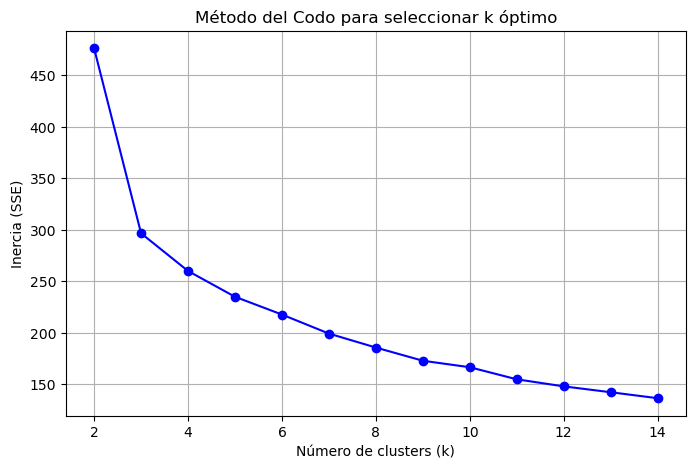

In [13]:
inertias=elbow_method(dataframe_pca.values, range(2, 15))

#### davies bouldin

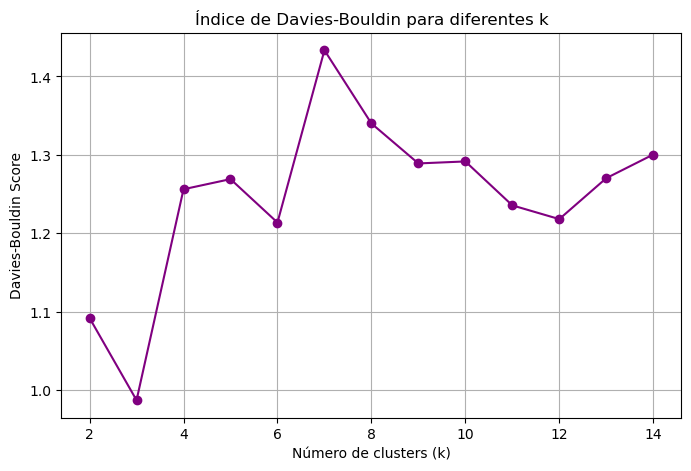

{2: np.float64(1.0919296374343106), 3: np.float64(0.9871262794413841), 4: np.float64(1.2561582769315878), 5: np.float64(1.2690738038872258), 6: np.float64(1.2137061036384769), 7: np.float64(1.433437409709334), 8: np.float64(1.3400824880097435), 9: np.float64(1.2890745991387902), 10: np.float64(1.2916186168885289), 11: np.float64(1.2355933210441372), 12: np.float64(1.2180803677049852), 13: np.float64(1.2702695722067743), 14: np.float64(1.3004228864111371)}


In [14]:
db_scores=plot_davies_bouldin_scores(dataframe_pca.values, range(2, 15))

print(db_scores)

#### Calinski-Harabasz

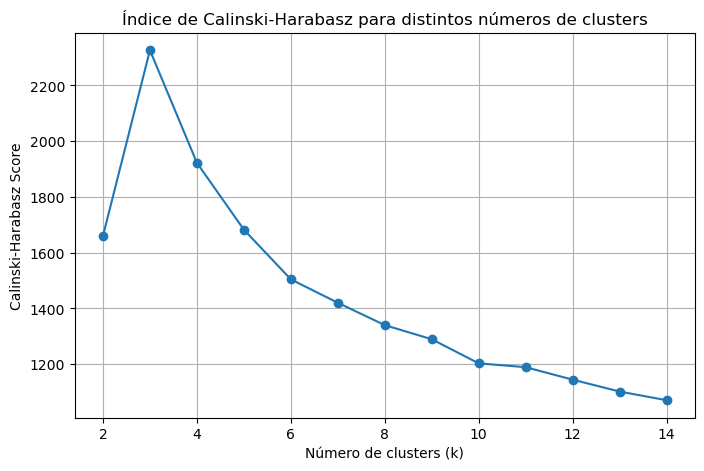

[np.float64(1659.8964492375555), np.float64(2326.382845859221), np.float64(1922.5013160507885), np.float64(1682.5212124040647), np.float64(1504.3166917106398), np.float64(1420.1866312811355), np.float64(1340.007356868633), np.float64(1289.3965827255251), np.float64(1202.9245438940222), np.float64(1189.1148682745725), np.float64(1144.3876327943415), np.float64(1101.667958546428), np.float64(1070.578895592076)]


In [15]:
ch_scores=evaluar_calinski_harabasz(dataframe_pca.values, range(2, 15))

print(ch_scores)

#### K-means con 3 cluster

Run ID final clustering: d4a468fde9a04e85be663ccf63b7e6f4
🏃 View run Final_Clustering_k=3 at: http://localhost:5000/#/experiments/940887523690596510/runs/d4a468fde9a04e85be663ccf63b7e6f4
🧪 View experiment at: http://localhost:5000/#/experiments/940887523690596510


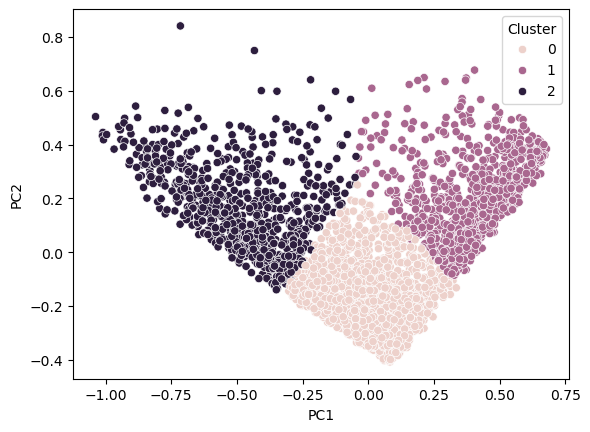

In [16]:
data_pca_cluster=kmeans_clustering_mlflow(dataframe_pca, ['PC1', 'PC2','PC3','PC4','PC5'],10,3,'K-Means_Clientes_Locales')


sns.scatterplot(data=data_pca_cluster,x='PC1',y='PC2',hue='Cluster')
plt.show()



In [17]:
data_pca_cluster

PC1       PC2       PC3       PC4       PC5  Cluster
3    -0.269982 -0.142595  0.017760  0.028126  0.061311        0
4     0.467073  0.084575  0.190151  0.003781  0.016909        1
5    -0.064354 -0.051997  0.000188 -0.292406  0.316180        0
6    -0.374178  0.265024 -0.053286 -0.122208  0.157205        2
7     0.113712 -0.214248 -0.068477 -0.032582 -0.064566        0
...        ...       ...       ...       ...       ...      ...
3909  0.187409 -0.208067 -0.141430 -0.022445  0.063246        0
3910  0.564912  0.279382 -0.261119  0.026075  0.012780        1
3911  0.409214  0.025858 -0.197157  0.042390  0.017249        1
3912  0.018475 -0.331887 -0.063661  0.079497  0.011703        0
3914 -0.344419  0.085946 -0.221417 -0.153878 -0.223631        2

[3284 rows x 6 columns]

In [18]:
id_cliente.index = data_pca_cluster.index

In [19]:
data_pca_cluster['id_cliente'] = id_cliente

In [20]:
data_pca_cluster = data_pca_cluster[['id_cliente', 'PC1', 'PC2','PC3','PC4','PC5', 'Cluster']]

data_pca_cluster.head()

id_cliente       PC1       PC2       PC3       PC4       PC5  Cluster
3     12820.0 -0.269982 -0.142595  0.017760  0.028126  0.061311        0
4     12821.0  0.467073  0.084575  0.190151  0.003781  0.016909        1
5     12822.0 -0.064354 -0.051997  0.000188 -0.292406  0.316180        0
6     12823.0 -0.374178  0.265024 -0.053286 -0.122208  0.157205        2
7     12824.0  0.113712 -0.214248 -0.068477 -0.032582 -0.064566        0

In [21]:
rfm_clientes_locales_clean['Cluster']=data_pca_cluster['Cluster']
rfm_clientes_locales_clean['id_cliente']=id_cliente


In [22]:
rfm_clientes_locales_clean.head()

Recency  Frequency  Monetary  horario_promedio  2010-12  2011-01  2011-02  \
3        4          4    942.34                13      0.0   170.46      0.0   
4      215          1     92.72                15      0.0     0.00      0.0   
5       71          2    948.88                13      0.0     0.00      0.0   
6       75          5   1759.50                12      0.0     0.00    535.5   
7       60          1    397.12                12      0.0     0.00      0.0   

   2011-03  2011-04  2011-05  2011-06  2011-07  2011-08  2011-09  2011-10  \
3      0.0      0.0     0.00      0.0      0.0      0.0   217.77   343.76   
4      0.0      0.0    92.72      0.0      0.0      0.0     0.00     0.00   
5      0.0      0.0     0.00      0.0      0.0      0.0   948.88     0.00   
6    459.0      0.0     0.00      0.0      0.0    229.5   535.50     0.00   
7      0.0      0.0     0.00      0.0      0.0      0.0     0.00   397.12   

   2011-11  2011-12  Cluster  id_cliente  
3      0.0   210.35        0     12820.0  
4      0.0     0.00        1     12821.0  
5      0.0     0.00        0     12822.0  
6      0.0     0.00        2     12823.0  
7      0.0     0.00        0     12824.0

In [24]:
rfm_clientes_locales_clean.columns

Index(['Recency', 'Frequency', 'Monetary', 'horario_promedio', '2010-12',
       '2011-01', '2011-02', '2011-03', '2011-04', '2011-05', '2011-06',
       '2011-07', '2011-08', '2011-09', '2011-10', '2011-11', '2011-12',
       'Cluster', 'id_cliente'],
      dtype='object')

In [25]:
cluster_summary = rfm_clientes_locales_clean.groupby('Cluster').mean(numeric_only=True)
display(cluster_summary)

Recency  Frequency     Monetary  horario_promedio    2010-12  \
Cluster                                                                    
0         49.018519   2.026882   514.908853         12.724014  18.113297   
1        228.836471   1.516471   387.481965         12.518824  24.861047   
2         38.206579   5.543421  1770.825605         12.609211  99.843921   

           2011-01    2011-02     2011-03     2011-04     2011-05     2011-06  \
Cluster                                                                         
0        10.172162  12.396302   18.373441   16.433292   22.082975   20.587760   
1        42.226318  47.449494   70.961612   55.448871   64.249776   47.024059   
2        85.682355  93.943158  113.711750  107.842092  138.103803  113.728724   

            2011-07     2011-08     2011-09     2011-10     2011-11  \
Cluster                                                               
0         23.471989   40.513632   85.189791  104.869247  120.491691   
1         35.260788    0.000000    0.000000    0.000000    0.000000   
2        127.141145  125.224329  219.604882  203.021658  264.928882   

           2011-12    id_cliente  
Cluster                           
0        22.213274  15584.108124  
1         0.000000  15543.364706  
2        78.048908  15548.686842

In [26]:
cluster_summary.columns

Index(['Recency', 'Frequency', 'Monetary', 'horario_promedio', '2010-12',
       '2011-01', '2011-02', '2011-03', '2011-04', '2011-05', '2011-06',
       '2011-07', '2011-08', '2011-09', '2011-10', '2011-11', '2011-12',
       'id_cliente'],
      dtype='object')

##### Gasto promedio en cada periodo

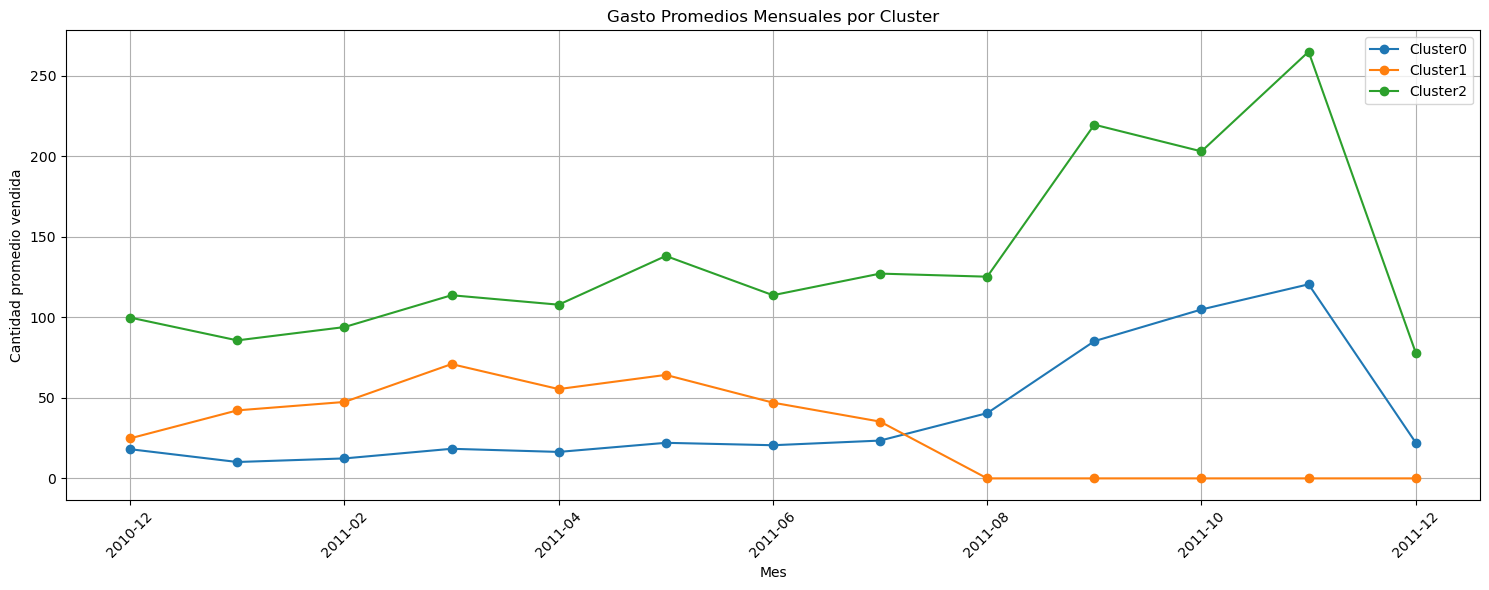

In [28]:
cluster0_mes= cluster_summary.iloc[0].T
cluster1_mes= cluster_summary.iloc[1].T
cluster2_mes= cluster_summary.iloc[2].T

columnas_fechas = [col for col in rfm_clientes_locales_clean.columns if col.startswith('201')]

cluster0_mes=cluster0_mes[columnas_fechas]
cluster1_mes=cluster1_mes[columnas_fechas]
cluster2_mes=cluster2_mes[columnas_fechas]

ventas_promedios_mensuales=pd.concat([cluster0_mes,cluster1_mes,cluster2_mes],axis=1)
ventas_promedios_mensuales.columns=['Cluster0','Cluster1','Cluster2']

ventas_promedios_mensuales.plot(
    figsize=(15, 6),
    title='Gasto Promedios Mensuales por Cluster',
    marker='o' ,
    markersize=6 )

plt.xlabel("Mes")
plt.ylabel("gasto promedio mensual")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

##### RFM

In [29]:
rfm_columnas=['Recency', 'Frequency', 'Monetary']
cluster0_rfm=cluster_summary.iloc[0].T
cluster1_rfm=cluster_summary.iloc[1].T
cluster2_rfm=cluster_summary.iloc[2].T

cluster0_rfm=cluster0_rfm[rfm_columnas]
cluster1_rfm=cluster1_rfm[rfm_columnas]
cluster2_rfm=cluster2_rfm[rfm_columnas]

rfm_promedio_cluster=pd.concat([cluster0_rfm,cluster1_rfm,cluster2_rfm],axis=1)
rfm_promedio_cluster.columns=['Cluster 0','Cluster 1','Cluster 2']


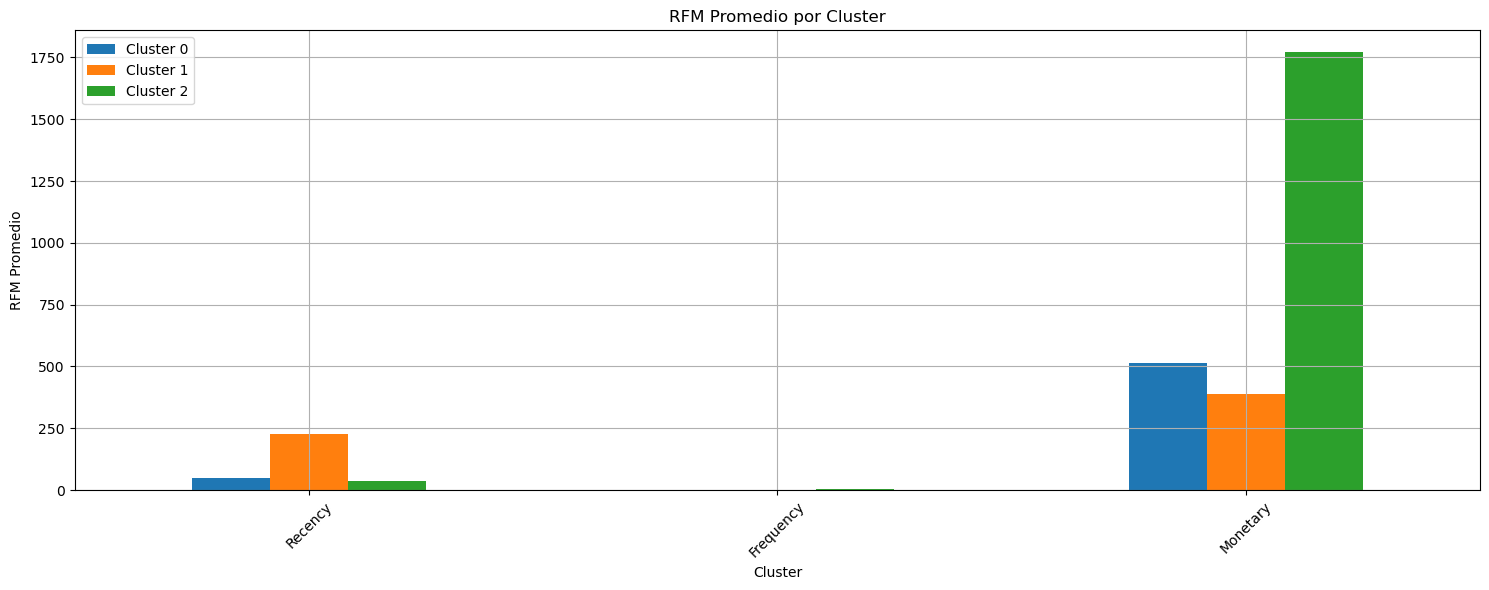

In [30]:
rfm_promedio_cluster.plot(kind='bar', figsize=(15, 6))
plt.title('RFM Promedio por Cluster')
plt.xlabel('Cluster')
plt.ylabel('RFM Promedio')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()